# Defaultable Asset


i found the idea for this project in the papers:
* "A defaultable callable bond pricing model" David Hua , Heng-Chih Chou , David Wang 
* "Introduction to the Numerical Solution of Partial Differential Equations in Finance" Claus Munk

## Zero Coupon Bond

to price a zero coupon bond the "Duffie and Singleton" model suggest to discount the final value at a default adjusted rate:
$$ R=r+h*L $$
* h is the hazard rate 
* L is the loss rate 
* r is the risk free rate 


the dynamic of R and h follow two CIR model:

$$ dR=a_R(b_R-R)dt + \sqrt{R} \sigma_R dW_R    $$
$$ dh=a_h(b_h-h)dt + \sqrt{h} \sigma_R dW_h    $$

### Bulding the PDE

the steps to find the pricing PDE are:
1) Using the ITO's lemma we can find, starting from the 2 CIR model the instantaneous mean and the standard deviation w.r h and R of a new process considering that wiener are correlated.
$$   \mu(f)= \frac{df}{dt}+ \frac{df}{dR}a_R(b_R-R)+ \frac{df}{dh}a_h(b_h-h)+\frac{(\sigma_R\sqrt{R})^2}{2}\frac{d^2f}{dR^2}+\rho\sigma_R\sqrt{R}\sigma_h\sqrt{h}\frac{d^2f}{dRdh}+\frac{(\sigma_h\sqrt{h})^2}{2}\frac{d^2f}{dh^2}     $$
$$   \sigma_R(f)=\frac{df}{dR}\sigma_R\sqrt{R}    $$
$$   \sigma_h(f)=\frac{df}{dh}\sigma_h\sqrt{h}    $$

2) by creating a istantaneous risk free portfolio with 3 bonds and after some computation we obtain the equation:
$$ \mu-R = \lambda_R\sigma_R+\lambda_h\sigma_h$$
3) Substituting the parameters obtained in the first step with the mu and sigma of the second we obtai the pricing PDE:
$$    \frac{df}{dt} + \frac{df}{dR}[a_R(b_R-R)-\lambda_R\sigma_R\sqrt{R}]+\frac{df}{dh}[a_h(b_h-h)-\lambda_h\sigma_h\sqrt{h}]+\frac{(\sigma_R\sqrt{R})^2}{2}\frac{d^2f}{dR^2}+\rho\sigma_R\sqrt{R}\sigma_h\sqrt{h}\frac{d^2f}{dRdh}+\frac{(\sigma_h\sqrt{h})^2}{2}\frac{d^2f}{dh^2}-Rf=0                                  $$

watching the PDE we can notice that to solve it with the finite difference method i'm gonna need a 3D grid.
 

### Conditions
to solve the PDE we are going to need some conditions:
1) $$ \lim_{R \to  0} f(R,h,t) = f(R,h,T)$$
2) $$ \lim_{R \to +\infty} f(R,h,t) = 0$$
3) $$ \lim_{h \to  0} f(R,h,t) = fe^{-r(T-t)}$$
4) $$ \lim_{h \to +\infty} f(R,h,t) = 0$$
5) $$f(R,h,T)=P+K$$
where P is the face value and K the final coupon.

like that i have 4 boundary condition that fix value for lateral face of my 3D grid and 1 final condition that fix value for the opposite face to the one that i have to find values (face f(R,h,0), and using the finite difference method i can solve the PDE.

## Coupon Bond

with the same pricing function i can price also Coupon Bond, it's enough to fix the value of the coupon (that for simplicity is K in my code), the idea is to use a jump model, so to decrease the price of the bond of K every time tc that the bond pays the coupon, i considered that bonds pays coupon every 6 months.
$$        \lim_{t \to  t_c^-} f(R,h,t) = \lim_{t \to  t_c^+} f(R,h,t) +K    $$

## Credit Default Swap 

from the paper "Introduction to the Numerical Solution of Partial Differential Equations in Finance" Claus Munk i found that i can price  the CDs from the protection seller’s point of view, the price is the same as a defaultable bond with:
* coupon payment K that corresponds to the premium payments
* face value equals zero

## Finite difference method 
here i add euation that i used to approximate derivatives
$$\frac{df}{dt}=\frac{f_{i,j,k}-f_{i,j,k-1}}{\Delta t}             $$
$$\frac{df}{dh}=\frac{f_{i,j+1,k}-f_{i,j-1,k}}{2\Delta h}             $$
$$\frac{d^2f}{dh^2}=     \frac{f_{i,j+1,k}-2f_{i,j,k}+f_{i,j-1,k}}{\Delta R^2}             $$

$$\frac{df}{dR}=\frac{f_{i+1,j,k}-f_{i-1,j,k}}{2\Delta R}             $$
$$ \frac{d^2f}{dR^2}=     \frac{f_{i+1,j,k}-2f_{i,j,k}+f_{i-1,j,k}}{\Delta R^2} $$  
$$ \frac{d^2f}{dRdh}=     \frac{f_{i+1,j+1,k}-f_{i+1,j-1,k}-f_{i-1,j+1,k}+f_{i-1,j-1,k}}{4\Delta R\Delta h} $$  

For this method is enough to substitute the approximation to the derivatives in the PDE and solve the resulting equation for f_{i,j,k-1}.
than we can apply this method to the grid solving backward the PDE

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import RegularGridInterpolator
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [6]:
# i used for simplicity parameters that i found in the paper "A defaultable callable bond pricing model" David Hua , Heng-Chih Chou , David Wang 
aR=.35
bR=.2
sigmaR=.15
lambdaR=-.5
L=.5
ah=.3
bh=.15
sigmah=.1
lambdah=-.5
rho=.2
P=100.0
T=2
K=5
Rmax=1
hmax=1

In [3]:
# here i created a generic finite difference class, that allow me to price in different way my assets, in this project i just used 1 method so i could've
# written just 1 class for pricing 

class fin_diff(object):
    def __init__(self,aR,bR,sigmaR,lambdaR,L,ah,bh,sigmah,lambdah,P,T,K,Rmax,hmax,rho,tc=30*6,coupon=False,cds=False):

        self.cds=cds
        self.tc=tc
        self.coupon=coupon
        self.aR=aR
        self.bR=bR
        self.sigmaR=sigmaR
        self.lambdaR=lambdaR
        self.L=L
        self.ah=ah
        self.bh=bh
        self.sigmah=sigmah
        self.lambdah=lambdah
        self.rho=rho
        self.P=P
        self.T=T
        self.K=K
        self.Rmax=Rmax
        self.hmax=hmax
        self.dt=1/360
        self.dR=Rmax/100
        self.dh=hmax/100
        self.hv=np.arange(0,self.hmax+self.dh,self.dh)
        self.Rv=np.arange(0,self.Rmax+self.dR,self.dR)
        self.tv=np.arange(0,self.T+self.dt,self.dt)
        self.grid=np.zeros((len(self.Rv),len(self.hv),len(self.tv)))

    def _set_bounds_ (self):
        
        pass

    def _grid_solve_ (self):

        pass
    
    def fct_solver(self):

        """this method has to been used before 'price', '_plot_price_surface_' and  _hR_price_dynamic_ methods.
            this method allow me to compute price and dynamics for assets with different h, R or both 
            without wasting time in new computation """ 

        self._set_bounds_()
        self._grid_solve_()

    def price(self,h_lev,R_lev,t_lev_in_days):

        """this method interpolate from the 3D grid the price of an asset with a specific h and a specific R"""

        t=t_lev_in_days/(360*self.T)
        interp=RegularGridInterpolator((self.Rv,self.hv,self.tv),self.grid[:,:,:])
        
        return interp((h_lev,R_lev,t))
    
    def _plot_price_surface_(self):

        pass

    def _hR_price_dynamic_(self,fixed_h,fixed_R):
        
        pass

In [4]:
class defaultable_asset(fin_diff):
        def _set_bounds_ (self):

                """this method set boundary and final conditions to the grid,
                 keeping in count if the asset is a Coupon Bond, a ZCB or a CDs"""
                 
                self.grid=np.zeros((len(self.Rv),len(self.hv),len(self.tv)))
                self.grid[:,-1,:]=0
                self.grid[:,0,:]=(self.P+self.K)*np.exp(-(np.dot(np.atleast_2d(self.Rv).T,T-np.atleast_2d(self.tv))))
                self.grid[0,:,:]=self.P+self.K
                #nothing
                if self.coupon==False and self.cds==True:
                        return print('your asset is not a zcb, not a cb and not a cds')
                        exit
                #cds
                elif self.coupon==True and self.cds==True:
                        self.grid[:,:,-1]=0
                #zcb
                elif self.coupon==False and self.cds==False:
                        self.grid[:,:,-1]=self.P+self.K
                #cb
                elif self.coupon==True and self.cds==False:
                        self.grid[:,:,-1]=self.P
                self.grid[-1,:,:]=0
                
        def _grid_solve_ (self):

                """this method apply the finite difference method starting from t=T and arriving to t=0, in that way define all points in the grid.
                also that method keep in count the asset that i'm computing the grid for """

                for t in range(len(self.grid[0,0,:])-1,0,-1):
                        if t%self.tc==0 and t!=0 and self.coupon==True:
                                self.grid[:,:,t]= self.grid[:,:,t]+self.K  
                        for i in range(1,len(self.grid[:,0,0])-1):
                                for j in range(1,len(self.grid[0,:,0])-1):
                                        a1=self.grid[i,j,t]
                                        a= (self.grid[i+1,j,t]-self.grid[i-1,j,t])*(self.aR*(self.bR-i*self.dR)-self.lambdaR*self.sigmaR*np.sqrt(i*self.dR))/(2*self.dR)
                                        b=(self.grid[i,j+1,t]-self.grid[i,j-1,t])*(self.ah*(self.bh-j*self.dh)-self.lambdah*self.sigmah*np.sqrt(j*self.dh))/(2*self.dh)
                                        c=((self.sigmaR*np.sqrt(i*self.dR))**2)*(self.grid[i+1,j,t]-2*self.grid[i,j,t]+self.grid[i-1,j,t])/(2*self.dR**2)
                                        d=((self.sigmah*np.sqrt(j*self.dh))**2)*(self.grid[i,j+1,t]-2*self.grid[i,j,t]+self.grid[i,j-1,t])/(2*self.dh**2)
                                        e=-self.grid[i,j,t]*self.dR*i
                                        f=self.rho*self.sigmaR*np.sqrt(self.dR*i)*np.sqrt(self.dh*j)*self.sigmah*(self.grid[i+1,j+1,t]-self.grid[i+1,j-1,t]-self.grid[i-1,j+1,t]+self.grid[i-1,j-1,t])/(4*self.dR*self.dh)
                                        self.grid[i,j,t-1]=(a+b+c+d+e+f)*self.dt+a1
        
        
        def _price_surface_(self):

                """this method plot the price surface with respect to h and R """

                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                RRvv,hhvv=np.meshgrid(self.Rv,self.hv)
                surf = ax.plot_surface(hhvv,RRvv,  self.grid[:,:,0], cmap=cm.coolwarm)
                ax.set_xlabel('h')
                ax.set_ylabel('R')
                ax.set_zlabel('price')

                if self.cds==True:
                        ax.set_xlim(0, self.hmax)
                        ax.set_ylim(0, self.Rmax)
                        ax.set_zlim(0, 80)
                        ax.set_title('Credit Default Swap price w.r. h and R')
                        ax.view_init(20, 30)

                elif self.coupon==False:

                        ax.set_xlim(0, self.hmax)
                        ax.set_ylim(0, self.Rmax)
                        ax.set_zlim(0, self.P+self.K)
                        ax.set_title('Zero Coupon bond price w.r. h and R')

                else:
                        ax.set_xlim(0, self.hmax)
                        ax.set_ylim(0, self.Rmax)
                        ax.set_zlim(0, self.P+self.K)
                        ax.set_title('Coupon bond price w.r. h and R')


                fig.colorbar(surf)
                
                return fig , ax

        def _hR_price_dynamic_(self,fixed_h,fixed_R):

                """this method plot the dynamic in time of an asset (CB,ZCB,CDs) with specified h and R """

                #dyn=[]
                #for i in range(360*self.T+1):
                        #dyn.append(self.price(fixed_h,fixed_R,i))
                dyn=self.grid[int(fixed_h/self.dh),int(fixed_R/self.dR),:]
                plt.xlabel('time')
                plt.ylabel('price')
                if self.cds==True and self.coupon==True:
                        plt.title('dynamic of a CDs price in time for h= {} and R={}'.format(fixed_h,fixed_R))
                elif self.cds==False and self.coupon==True:
                        plt.title('dynamic of a Coupon Bond price in time for h= {} and R={}'.format(fixed_h,fixed_R))
                elif self.cds==False and self.coupon==False:
                        plt.title('dynamic of a Zero Coupon Bond price in time for h= {} and R={}'.format(fixed_h,fixed_R))
                return plt.plot(self.tv,dyn)




In [7]:
#1) to use my classes i need at the beginning to create an instance on the basis of my parameters and of the type of asset that i want to price (cb,zcb or cds)

zcb=defaultable_asset(aR,bR,sigmaR,lambdaR,L,ah,bh,sigmah,lambdah,P,T,K,Rmax,hmax,rho)
cb=defaultable_asset(aR,bR,sigmaR,lambdaR,L,ah,bh,sigmah,lambdah,P,T,K,Rmax,hmax,rho,coupon=True)
cds=defaultable_asset(aR,bR,sigmaR,lambdaR,L,ah,bh,sigmah,lambdah,P,T,K,Rmax,hmax,rho,coupon=True,cds=True)

#2) i need to call the method 'fct_solver' that set boundary and solve my grid w.r. my parameters and keeping in count the type of asset 

cb.fct_solver()
zcb.fct_solver()
cds.fct_solver()

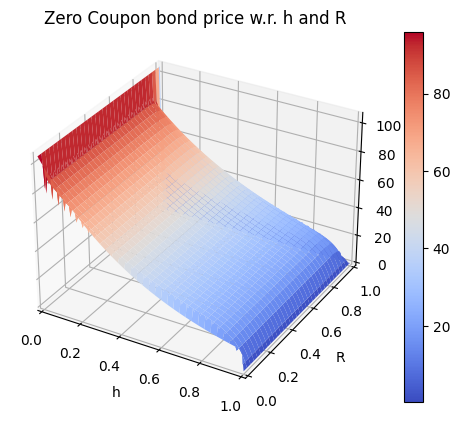

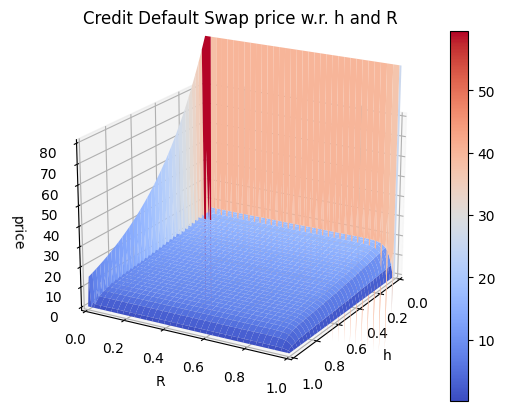

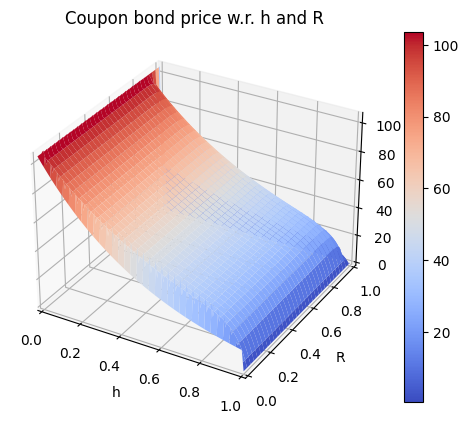

In [8]:
#3) just calling the method _price_surface_ and the method to show the plot i'm going to obtain the surface of price w.r. to h and R

zcb._price_surface_()
plt.show()
cds._price_surface_()
plt.show()
cb._price_surface_()
plt.show()

In [9]:
#4) instead of calling all the surface of prices i can just call the function 'price' 
#   to observe the price of the asset in a specific time at specific level of h and R

print(cb.price(h_lev=0.99,R_lev=0.1073,t_lev_in_days=40))
print(zcb.price(h_lev=0.99,R_lev=0.1073,t_lev_in_days=40))
print(cds.price(h_lev=0.99,R_lev=0.1073,t_lev_in_days=40))

5.204959084199382
3.9400551258055465
1.4525273566498853


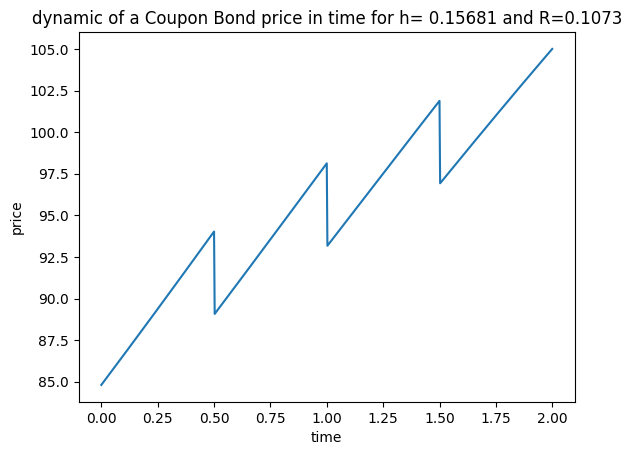

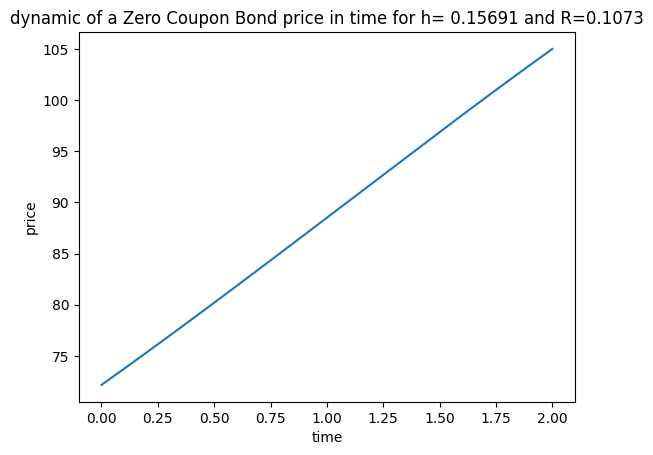

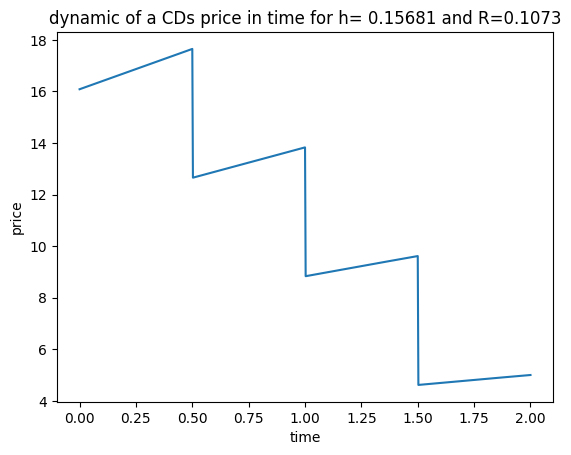

In [10]:
#5) calling the function '_hR_price_dynamic_' i can study the dynamic in time of a specific asset (zcb,cb,cds)
#   for specific value of h and R

cb._hR_price_dynamic_(0.15681,0.1073)
plt.show()
zcb._hR_price_dynamic_(0.15691,0.1073)
plt.show()
cds._hR_price_dynamic_(0.15681,0.1073)
plt.show()